# ANN

Here I've coded an artificial neural network with an arbitrary number of layers. The ANN is encoded in a class, and is fed a dictionary of your choices for activation functions and loss functions, as well as a list of the neurons in each layer, for example a two layer network with 100 and 50, respectively, is fed as [100,50].

Then, the easiest way to search for effective parameters sets is to use RunOne or RunTwo. RunOne will train a one layer NN across the list of options you feed it, then test its accuracy. For example, [10,20,30] will train with 10 neurons, 20 neurons, 30 neurons, and spit out the accuracy for each. Similarly, RunTwo trains in a list of two lists, the first for the number of neurons in the first layer and the second for the second layer. It will train across all combinations and sit out a matrix of accuracies.

Then, once you've identified a good parameter set, use the solitary Train function grouped with RunOne and RunTwo in order to train one a specific parameter set. 

## Load Data Functions

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
%matplotlib inline 

def read_dataset(feature_file, label_file):
    ''' Read data set in *.csv to data frame in Pandas'''
    df_X = pd.read_csv(feature_file)
    df_y = pd.read_csv(label_file)
    X = df_X.values # convert values in dataframe to numpy array (features)
    y = df_y.values # convert values in dataframe to numpy array (label)
    return X, y


def normalize_features(X_train, X_test):
    from sklearn.preprocessing import StandardScaler #import libaray
    scaler = StandardScaler() # call an object function
    scaler.fit(X_train) # calculate mean, std in X_train
    X_train_norm = scaler.transform(X_train) # apply normalization on X_train
    X_test_norm = scaler.transform(X_test) # we use the same normalization on X_test
    return X_train_norm, X_test_norm


def one_hot_encoder(y_train, y_test):
    ''' convert label to a vector under one-hot-code fashion '''
    from sklearn import preprocessing
    lb = preprocessing.LabelBinarizer()
    lb.fit(y_train)
    y_train_ohe = lb.transform(y_train)
    y_test_ohe = lb.transform(y_test)
    return y_train_ohe, y_test_ohe

## NN Class

In [3]:
class varlayer_NN:
    def __init__(self, X, y, DACT, DLOSS, hidden_layer=[100], lr=0.01):
        self.X = X # features
        self.y = y # labels (targets) in one-hot-encoder
        self.activation = DACT['F']
        self.derivative = DACT['D']
        self.lossfunction = DLOSS['F']
        self.lossderivative = DLOSS['D']
        self.regularization_parameter = DLOSS['RP']
        self.hidden_layer = hidden_layer # number of neuron in the hidden layer
        # In this example, we only consider 1 hidden layer
        self.lr = lr # learning rate
        # Initialize weights
        self.in_nn = X.shape[1] # number of neurons in the inpute layer              
        self.out_nn = y.shape[1]
        
        self.W = []
        self.b = []
        self.W.append(np.random.randn(self.in_nn,self.hidden_layer[0])/np.sqrt(self.in_nn))
        self.b.append(np.zeros((1,self.hidden_layer[0])))
        for i in range(0,len(self.hidden_layer)-1):
            self.W.append(np.random.randn(self.hidden_layer[i],self.hidden_layer[i+1])/np.sqrt(self.hidden_layer[i]))
            self.b.append(np.zeros((1,self.hidden_layer[i+1])))

        self.W.append(np.random.randn(self.hidden_layer[-1],self.out_nn)/np.sqrt(self.hidden_layer[-1]))
        self.b.append(np.zeros((1,self.out_nn)))
        self.C = [self.W,self.b]
        
    def feed_forward(self):
        # hidden layer
        self.z = []
        self.f = []
        ## z_1 = xW_1 + b_1
        self.z.append(np.dot(self.X, self.W[0]) + self.b[0])
        ## activation function :  f_1 = \tanh(z_1)
        self.f.append(self.activation(self.z[0]))
        for i in range(0,len(self.hidden_layer)-1):
            self.z.append(np.dot(self.f[i], self.W[i+1]) + self.b[i+1])
            self.f.append(self.activation(self.z[-1]))
        # output layer
        ## z_2 = f_1W_2 + b_2
        self.z.append(np.dot(self.f[-1], self.W[-1]) + self.b[-1])
        #\hat{y} = softmax}(z_2)$
        self.y_hat = softmax(self.z[-1])
        
        
    def back_propagation(self):
        d = []
        d.insert(0,self.lossderivative(self.y,self.y_hat,self.regularization_parameter,self.C))
        dW = []
        db = []
        for i in range(len(self.hidden_layer)):
            dW.insert(0,self.f[-1-i].T.dot(d[0]))
            db.insert(0,np.sum(d[0],axis=0,keepdims=True))
            d.insert(0,self.derivative(self.f[-1-i])*(d[0].dot(self.W[-1-i].T)))
        dW.insert(0,self.X.T.dot(d[0]))
        db.insert(0,np.sum(d[0],axis=0,keepdims=True))
        
        
        # Update the gradident descent
        if(self.regularization_parameter==None):
            for i in range(len(self.W)):            
                self.W[i] = self.W[i] - self.lr * dW[i]
                self.b[i] = self.b[i] - self.lr * db[i]
        else:
            for i in range(len(self.W)):
                self.W[i] = self.W[i] - self.lr * dW[i]
                if(self.W[i].all()!=0):
                    self.W[i] = self.W[i] - self.lr * self.W[i]/np.sqrt(np.sum(self.W[i]*self.W[i]))
                    
                self.b[i] = self.b[i] - self.lr * db[i]
                if(self.b[i].all()!=0):
                    self.b[i] = self.b[i] - self.lr * self.b[i]/np.sqrt(np.sum(self.b[i]*self.b[i]))


    def callloss(self):
        #  $L = -\sum_n\sum_{i\in C} y_{n, i}\log(\hat{y}_{n, i})$
        # calculate y_hat
        self.feed_forward()
        self.loss = self.lossfunction(self.y,self.y_hat,self.regularization_parameter,self.C)


    def predict(self, X_test):
        # Use feed forward to calculat y_hat_test
        # hidden layer
        ## z_1 = xW_1 + b_1
        z = np.dot(X_test, self.W[0]) + self.b[0]
        for i in range(1,len(self.hidden_layer)+1):
            f = self.activation(z)
            z = np.dot(f,self.W[i]) + self.b[i]
        y_hat_test = softmax(z)

        # the rest is similar to the logistic regression
        labels = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
        num_test_samples = X_test.shape[0]
        # find which index gives us the highest probability
        ypred = np.zeros(num_test_samples, dtype=int)
        for i in range(num_test_samples):
            ypred[i] = labels[np.argmax(y_hat_test[i,:])]
        return ypred
    
    def train(self,epochs):
        for i in range(epochs):
            self.feed_forward()
            self.back_propagation()
            self.callloss()
        
def softmax(z):
    exp_value = np.exp(z-np.amax(z, axis=1, keepdims=True)) # for stablility
    # keepdims = True means that the output's dimension is the same as of z
    softmax_scores = exp_value / np.sum(exp_value, axis=1, keepdims=True)
    return softmax_scores

def accuracy(ypred, yexact):
    p = np.array(ypred == yexact, dtype = int)
    return np.sum(p)/float(len(yexact))

## Activation and Loss Functions

Note: Not all combinations work, but the combo from class and the homework combo both work well. You're welcome to experiment with others!

In [4]:
#ACTIVATIONS
def TANH(X):
    return np.tanh(X)

def TANH_dx(X):
    return 1 - np.tanh(X)*np.tanh(X)

def RELU(X):
    dx = np.copy(X)
    dx[X<0] = 0
    return dx

def RELU_dx(X):
    dx = np.copy(X)
    dx[dx<0]=0
    dx[dx>0]=1
    return dx

#LOSSES
def CrossEntropyLoss(y,yhat,regularization_parameter=None,C=None):
    return -np.sum(y*np.log(yhat + 1e-6))

def CrossEntropyLoss_dx(y,yhat,regularization_parameter=None,C=None): #What?
    return yhat - y

def RegularizedLoss(y,yhat,regularization_parameter,C):
    loss = 0
    hinge = 1 - y*yhat
    hinge[hinge<0]=0
    loss = np.sum(hinge)
    loss *= regularization_parameter
    temp = 0
    for item in C:
        for elem in item:
            temp += np.sum(elem*elem)
    return loss + np.sqrt(temp)

def RegularizedLoss_dx(y,yhat,regularization_parameter,C):
    hinge = 1 - y*yhat
    summed = np.sum(y*yhat,axis=1,keepdims=True)
    loss = np.zeros(hinge.shape)
    for i in range(hinge.shape[0]):
        for j in range(hinge.shape[1]):
            if(hinge[i][j]>0):
                loss[i][j] = yhat[i][j]*(summed[i,:] - y[i][j])
    loss *= regularization_parameter
    return loss

def RegularizedLoss2(y,yhat,regularization_parameter,C):
    loss = 0
    hinge = 1 - y*yhat
    hinge = np.sum(hinge,axis=1,keepdims=True)
    hinge[hinge<0]=0
    loss = np.sum(hinge)
    loss *= regularization_parameter
    temp = 0
    for item in C:
        for elem in item:
            temp += np.sum(elem*elem)
    return loss + np.sqrt(temp)

def RegularizedLoss_dx2(y,yhat,regularization_parameter,C):
    hinge = 1 - y*yhat
    hinge = np.sum(hinge,axis=1,keepdims=True)
    summed = np.sum(y*yhat,axis=1,keepdims=True)
    loss = np.zeros(y.shape)
    for i in range(hinge.shape[0]):
        if(hinge[i]>0):
            loss[i] = yhat[i]*(summed[i] - y[i])
    loss *= regularization_parameter
    return loss

## The Run and Train Functions

dlib should be a library of the data, activation, and loss libraries. layerslist is a single list for RunOne and a list of two lists for RunTwo. For Train, the layerslist is interpretted as a list of neurons for each layer, so [100,50] is a NN with two layers, 100 then 50.

Note, you do not need to use these to train the NN, but I found it easier this way. You will need to train a three or more layer network by setting up a loop separately.

In [5]:
# RUN
def RunOne(dlib,layerslist,epochs,lr=0.1):
    data = dlib['DATA']
    dact = dlib['DACT']
    dloss = dlib['DLOSS']
    matrix = np.zeros(len(layerslist[0]))
    print('Running OneLayer NN with:\n   layer1:',layerslist[0],'\n   epochs:', epochs,'\n   lr:', lr)
    print('   ',dlib['DACT'])
    print('   ',dlib['DLOSS'],'\n')
    for i in range(len(layerslist[0])):
        l1 = layerslist[0][i]
        hidden_layer=[l1]
        myNN = varlayer_NN(data['X_train_norm'], data['y_train_ohe'], dact, dloss, hidden_layer, lr) 
        myNN.train(epochs)
        y_pred = myNN.predict(data['X_test_norm'])
        ac = 100*accuracy(y_pred, data['y_test'].ravel())
        matrix[i] = ac
        #print('Accuracy of our model_TEST: %f%%' % (ac))
        #print('   NEURONS: %d'%(l1))
    return matrix

def RunTwo(dlib,layerslist,epochs,lr=0.1):
    data = dlib['DATA']
    dact = dlib['DACT']
    dloss = dlib['DLOSS']
    matrix = np.zeros((len(layerslist[0]),len(layerslist[1])))
    print('Running TwoLayer NN with:\n   layer1:',layerslist[0],'\n   layer2:',layerslist[1],'\n   epochs:', epochs,'\n   lr:', lr)
    print('   ',dlib['DACT'])
    print('   ',dlib['DLOSS'],'\n')
    for i in range(len(layerslist[0])):
        for j in range(len(layerslist[1])):
            l1 = layerslist[0][i]
            l2 = layerslist[1][j]
            hidden_layer=[l1,l2]
            myNN = varlayer_NN(data['X_train_norm'], data['y_train_ohe'], dact, dloss, hidden_layer, lr) 
            myNN.train(epochs)
            y_pred = myNN.predict(data['X_test_norm'])
            ac = 100*accuracy(y_pred, data['y_test'].ravel())
            matrix[i][j] = ac
            #print('Accuracy of our model_TEST: %f%%' % (ac))
            #print('   NEURONS: %d %d'%(l1,l2))
    return matrix
            
def Train(dlib,layerslist,epochs,lr=0.1):
    data = dlib['DATA']
    dact = dlib['DACT']
    dloss = dlib['DLOSS']
    print('Running TwoLayer NN with:\n   layers:',layerslist,'\n   epochs:', epochs,'\n   lr:', lr)
    print('   ',dlib['DACT'])
    print('   ',dlib['DLOSS'],'\n')
    NN = varlayer_NN(data['X_train_norm'], data['y_train_ohe'], dact, dloss, layerslist, lr) 
    NN.train(epochs)
    y_pred = NN.predict(data['X_test_norm'])
    print('Accuracy of our model_TEST: %f%%' % (100*accuracy(y_pred, data['y_test'].ravel())))
    return NN

## Plotting functions

Plot_digit will plot an X Vector.

plot_test will plot a series of X Vectors, from index1 to index2, as well as show the label and prediction of the given NN. clearn_ is the NN, and data_ is the data dictionary used to train it.

tally_matrix and tally_matrix_no_diag both return a matrix where the rows are the label and the columns are the predictions, so entry 1,2 (counting from 1) would be the percentage of 1s classified as 2s.

In [6]:
#PLOTTING
import matplotlib.pyplot as plt
import IPython
%matplotlib inline

def plot_digit(feature_vector):
    dim = int(np.sqrt(len(feature_vector)))
    plt.gray()
    plt.matshow(feature_vector.reshape(dim,dim))
    plt.show()

def plot_test(index1,index2,clearn_,data_):
    for index in range(index1,index2):
        print('Image:',index)
        plot_digit(data_['X_test'][index])
        ypred = clearn_.predict(data_['X_test_norm'][index].reshape(1,-1))
        print('Label:', int(data_['y_test'][index]))
        print('Prediction:',int(ypred))
        print('')
        
def tally_matrix(y_test,pred):
    total=np.zeros(10)
    tal=np.zeros((10,10))
    for i in range(len(y_test)):
        y=int(y_test[i])
        p=int(pred[i])
        tal[y][p]+=1
        total[y]+=1
    for index in range(tal.shape[0]):
        tal[index] *= 100/total[index]
    return tal
        
def tally_matrix_no_diag(y_test,pred):
    total=np.zeros(10)
    tal=np.zeros((10,10))
    for i in range(len(y_test)):
        y=int(y_test[i])
        p=int(pred[i])
        if(y!=p):
            tal[y][p]+=1
        total[y]+=1
    for index in range(tal.shape[0]):
        tal[index] *= 100/total[index]
    return tal

## Load the data

In [7]:
# main
#X_train_digits, y_train_digits = read_dataset('Digits_X_train.csv', 'Digits_y_train.csv')
#X_test_digits, y_test_digits = read_dataset('Digits_X_test.csv', 'Digits_y_test.csv')
#X_train_norm_digits, X_test_norm_digits = normalize_features(X_train_digits, X_test_digits)
#y_train_ohe_digits, y_test_ohe_digits = one_hot_encoder(y_train_digits, y_test_digits)

X_train_mnist, y_train_mnist = read_dataset('MNIST_X_train.csv', 'MNIST_y_train.csv')
X_test_mnist, y_test_mnist = read_dataset('MNIST_X_test.csv', 'MNIST_y_test.csv')
X_train_norm_mnist, X_test_norm_mnist = normalize_features(X_train_mnist, X_test_mnist)
y_train_ohe_mnist, y_test_ohe_mnist = one_hot_encoder(y_train_mnist, y_test_mnist)

/usr/local/lib/python3.7/site-packages/sklearn/utils/validation.py:590: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/usr/local/lib/python3.7/site-packages/sklearn/utils/validation.py:590: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/usr/local/lib/python3.7/site-packages/sklearn/utils/validation.py:590: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


## Define the dictionaries to use in training

In [9]:
#Libraries
#ACTIVATIONS
DRELU = {'F':RELU,'D':RELU_dx}
DTANH = {'F':TANH,'D':TANH_dx}

#LOSS
DENTR = {'F':CrossEntropyLoss,'D':CrossEntropyLoss_dx,'RP':0.1}
DREGU = {'F':RegularizedLoss,'D':RegularizedLoss_dx,'RP':0.1}
DREGU2 = {'F':RegularizedLoss2,'D':RegularizedLoss_dx2,'RP':0.1}

#DATA
#DDIG = {'X_train':X_train_digits,'X_train_norm':X_train_norm_digits,'y_train':y_train_digits,'y_train_ohe':y_train_ohe_digits,\
#        'X_test':X_test_digits,'X_test_norm':X_test_norm_digits,'y_test':y_test_digits,'y_test_ohe':y_test_ohe_digits}
DMNI = {'X_train':X_train_mnist,'X_train_norm':X_train_norm_mnist,'y_train':y_train_mnist,'y_train_ohe':y_train_ohe_mnist,\
        'X_test':X_test_mnist,'X_test_norm':X_test_norm_mnist,'y_test':y_test_mnist,'y_test_ohe':y_test_ohe_mnist}

## Test on Digits data

The Digits data seems to max out around 96-98% accuracy on a wide range of neuron layer combinations, for both one and two layers. The final results vary upon new trainings, but this range is typical.

In [8]:
DATA = DDIG
DACT = DRELU
DLOSS = DREGU2
DLOSS['RP']=0.1
DLIB = {'DATA':DATA,\
        'DACT':DACT,\
        'DLOSS':DLOSS}

L1 = [10,20,30]
L2 = [10,20,30]
layers = [L1,L2]
epoch_num = 200
lr=0.01


layers = [L1]
matrix1 = RunOne(DLIB,layers,epoch_num,lr)
print('OneLayer Accuracy:')
print(matrix1)
print('')
layers = [L1,L2]
matrix2 = RunTwo(DLIB,layers,epoch_num,lr)
print('TwoLayer Accuracy:')
print(matrix2)

Running OneLayer NN with:
   layer1: [10, 20, 30] 
   epochs: 200 
   lr: 0.01
    {'F': <function RELU at 0x115c00510>, 'D': <function RELU_dx at 0x115c00620>}
    {'F': <function RegularizedLoss2 at 0x115c00ae8>, 'D': <function RegularizedLoss_dx2 at 0x115c00b70>, 'RP': 0.1} 

OneLayer Accuracy:
[94.         94.88888889 95.77777778]

Running TwoLayer NN with:
   layer1: [10, 20, 30] 
   layer2: [10, 20, 30] 
   epochs: 200 
   lr: 0.01
    {'F': <function RELU at 0x115c00510>, 'D': <function RELU_dx at 0x115c00620>}
    {'F': <function RegularizedLoss2 at 0x115c00ae8>, 'D': <function RegularizedLoss_dx2 at 0x115c00b70>, 'RP': 0.1} 

TwoLayer Accuracy:
[[92.22222222 95.77777778 93.33333333]
 [95.33333333 94.66666667 96.22222222]
 [95.11111111 95.77777778 97.55555556]]


## First run on MNIST Data

Across networks of small numbers of neurons, my network maxes out around 92.4% accuracy with 70x65 two layer NN, with a close second of 92% for 75x65. Across all combinations of 50-80 by fives, the range is tight with 89-92.4% accuracy. However, the results for each combination vary by at least +-1% upon each new training. 

The MNIST data seems more sensitive to variations than the Digits data, likely due to its more complex nature. In both the Digits and MNIST data, the two layer functioned marginally better, by less than 1%. Considering that the accuracy results of each combination tend to vary by about a percentage point, this is not considerable.

In [9]:
DATA = DMNI
DACT = DRELU
DLOSS = DREGU2
DLOSS['RP']=0.1
DLIB = {'DATA':DATA,\
        'DACT':DACT,\
        'DLOSS':DLOSS}

L1 = [10,20,30]
L2 = [10,20,30]
layers = [L1,L2]
epoch_num = 200
lr=0.01


layers = [L1]
matrix1 = RunOne(DLIB,layers,epoch_num,lr)
print('OneLayer Accuracy:')
print(matrix1)
print('')
layers = [L1,L2]
matrix2 = RunTwo(DLIB,layers,epoch_num,lr)
print('TwoLayer Accuracy:')
print(matrix2)

Running OneLayer NN with:
   layer1: [10, 20, 30] 
   epochs: 200 
   lr: 0.01
    {'F': <function RELU at 0x115c00510>, 'D': <function RELU_dx at 0x115c00620>}
    {'F': <function RegularizedLoss2 at 0x115c00ae8>, 'D': <function RegularizedLoss_dx2 at 0x115c00b70>, 'RP': 0.1} 

OneLayer Accuracy:
[87.8 90.  90.6]

Running TwoLayer NN with:
   layer1: [10, 20, 30] 
   layer2: [10, 20, 30] 
   epochs: 200 
   lr: 0.01
    {'F': <function RELU at 0x115c00510>, 'D': <function RELU_dx at 0x115c00620>}
    {'F': <function RegularizedLoss2 at 0x115c00ae8>, 'D': <function RegularizedLoss_dx2 at 0x115c00b70>, 'RP': 0.1} 

TwoLayer Accuracy:
[[86.8 81.4 89. ]
 [89.4 89.8 90.2]
 [91.  89.4 91.2]]


## Second run on MNIST Data

Increasing the number of neurons, particularly in the first layer, barely brings down the accuracy to within fluctuation of the final result. On average, the smaller number of neurons fairs better, but barely. They also train substantially faster, so the smaller number of neurons in each layer takes the day.

In [11]:
DATA = DMNI
DACT = DRELU
DLOSS = DREGU2
DLOSS['RP']=0.1
DLIB = {'DATA':DATA,\
        'DACT':DACT,\
        'DLOSS':DLOSS}

L1 = [200,400,600,800]
L2 = [50,75,100,200]
layers = [L1,L2]
epoch_num = 200
lr=0.01


layers = [L1]
matrix1 = RunOne(DLIB,layers,epoch_num,lr)
print('OneLayer Accuracy:')
print(matrix1)
print('')
layers = [L1,L2]
matrix2 = RunTwo(DLIB,layers,epoch_num,lr)
print('TwoLayer Accuracy:')
print(matrix2)

Running OneLayer NN with:
   layer1: [200, 400, 600, 800] 
   epochs: 200 
   lr: 0.01
    {'F': <function RELU at 0x11531bbf8>, 'D': <function RELU_dx at 0x11531bc80>}
    {'F': <function RegularizedLoss2 at 0x11531bf28>, 'D': <function RegularizedLoss_dx2 at 0x1153f6048>, 'RP': 0.1} 

OneLayer Accuracy:
[91.6 92.  91.4 91.6]

Running TwoLayer NN with:
   layer1: [200, 400, 600, 800] 
   layer2: [50, 75, 100, 200] 
   epochs: 200 
   lr: 0.01
    {'F': <function RELU at 0x11531bbf8>, 'D': <function RELU_dx at 0x11531bc80>}
    {'F': <function RegularizedLoss2 at 0x11531bf28>, 'D': <function RegularizedLoss_dx2 at 0x1153f6048>, 'RP': 0.1} 

TwoLayer Accuracy:
[[90.8 91.  91.8 91.6]
 [90.2 90.2 91.8 91.8]
 [91.  90.8 91.2 91.8]
 [91.2 89.6 90.4 91.6]]


## Visualization of Results

I've trained a single dig_NN and single MNI_NN as example below. The training options, resulting accuracy, and error patterns are printed below. As in HW2, the misclassification rate is more spread amongst the number combinations in mnist, whereas the in digits the error is more concentrated in specific number combinations.

Running TwoLayer NN with:
   layers: [100, 50] 
   epochs: 200 
   lr: 0.01
    {'F': <function RELU at 0x11531bbf8>, 'D': <function RELU_dx at 0x11531bc80>}
    {'F': <function RegularizedLoss2 at 0x11531bf28>, 'D': <function RegularizedLoss_dx2 at 0x1153f6048>, 'RP': 0.1} 

Accuracy of our model_TEST: 96.444444%


Percent of row_num classified as col_num
No Diagonal for Images -- Correctly classified % set to zero
----------------------
classification: row  by column
classification: row=Label by col=Prediction
classification: true by classified

----------------------
DIGITS


<Figure size 432x288 with 0 Axes>

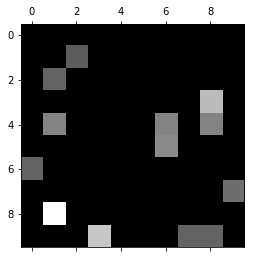

[[100.     0.     0.     0.     0.     0.     0.     0.     0.     0.  ]
 [  0.    98.08   1.92   0.     0.     0.     0.     0.     0.     0.  ]
 [  0.     2.04  97.96   0.     0.     0.     0.     0.     0.     0.  ]
 [  0.     0.     0.    96.15   0.     0.     0.     0.     3.85   0.  ]
 [  0.     2.7    0.     0.    91.89   0.     2.7    0.     2.7    0.  ]
 [  0.     0.     0.     0.     0.    97.14   2.86   0.     0.     0.  ]
 [  2.04   0.     0.     0.     0.     0.    97.96   0.     0.     0.  ]
 [  0.     0.     0.     0.     0.     0.     0.    97.73   0.     2.27]
 [  0.     5.26   0.     0.     0.     0.     0.     0.    94.74   0.  ]
 [  0.     0.     0.     4.08   0.     0.     0.     2.04   2.04  91.84]]


In [25]:
DATA = DDIG
DACT = DRELU
DLOSS = DREGU2
DLOSS['RP']=0.1

DLIB = {'DATA':DATA,\
        'DACT':DACT,\
        'DLOSS':DLOSS}
layerslist=[100,50]
epochs=200
lr=0.01

DIG_NN = Train(DLIB,layerslist,epochs,lr)
ypred = DIG_NN.predict(DATA['X_test_norm'])
dig_matrix_no_diag = tally_matrix_no_diag(DATA['y_test'],ypred)
ypred = DIG_NN.predict(DATA['X_test_norm'])
dig_matrix = tally_matrix(DATA['y_test'],ypred)

np.set_printoptions(precision=2)
plt.gray()
print('\n')
print('Percent of row_num classified as col_num')
print('No Diagonal for Images -- Correctly classified % set to zero')
print('----------------------')
print('classification: row  by column')
print('classification: row=Label by col=Prediction')
print('classification: true by classified')

print('\n----------------------')
print('DIGITS')
plt.matshow(dig_matrix_no_diag)
plt.show()
print(dig_matrix)

Running TwoLayer NN with:
   layers: [75, 65] 
   epochs: 200 
   lr: 0.01
    {'F': <function RELU at 0x11531bbf8>, 'D': <function RELU_dx at 0x11531bc80>}
    {'F': <function RegularizedLoss2 at 0x11531bf28>, 'D': <function RegularizedLoss_dx2 at 0x1153f6048>, 'RP': 0.1} 

Accuracy of our model_TEST: 91.600000%


Percent of row_num classified as col_num
No Diagonal for Images -- Correctly classified % set to zero
----------------------
classification: row  by column
classification: row=Label by col=Prediction
classification: true by classified

----------------------
MNIST


<Figure size 432x288 with 0 Axes>

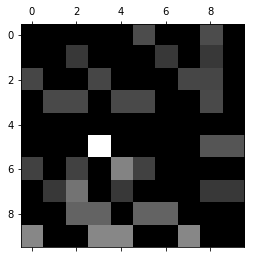

[[ 95.74   0.     0.     0.     0.     2.13   0.     0.     2.13   0.  ]
 [  0.    95.24   1.59   0.     0.     0.     1.59   0.     1.59   0.  ]
 [  1.96   0.    92.16   1.96   0.     0.     0.     1.96   1.96   0.  ]
 [  0.     2.08   2.08  89.58   2.08   2.08   0.     0.     2.08   0.  ]
 [  0.     0.     0.     0.   100.     0.     0.     0.     0.     0.  ]
 [  0.     0.     0.     7.14   0.    88.1    0.     0.     2.38   2.38]
 [  1.85   0.     1.85   0.     3.7    1.85  90.74   0.     0.     0.  ]
 [  0.     1.61   3.23   0.     1.61   0.     0.    90.32   1.61   1.61]
 [  0.     0.     2.78   2.78   0.     2.78   2.78   0.    88.89   0.  ]
 [  3.77   0.     0.     3.77   3.77   0.     0.     3.77   0.    84.91]]


In [26]:
DATA = DMNI
DACT = DRELU
DLOSS = DREGU2
DLOSS['RP']=0.1

DLIB = {'DATA':DATA,\
        'DACT':DACT,\
        'DLOSS':DLOSS}

layerslist=[75,65]
epochs=200
lr=0.01

MNI_NN = Train(DLIB,layerslist,epochs,lr)
ypred = MNI_NN.predict(DATA['X_test_norm'])
mni_matrix_no_diag = tally_matrix_no_diag(DATA['y_test'],ypred)
ypred = MNI_NN.predict(DATA['X_test_norm'])
mni_matrix = tally_matrix(DATA['y_test'],ypred)


np.set_printoptions(precision=2)
plt.gray()
print('\n')
print('Percent of row_num classified as col_num')
print('No Diagonal for Images -- Correctly classified % set to zero')
print('----------------------')
print('classification: row  by column')
print('classification: row=Label by col=Prediction')
print('classification: true by classified')

print('\n----------------------')
print('MNIST')
plt.matshow(mni_matrix_no_diag)
plt.show()
print(mni_matrix)

## Just some example labels and their predictions from the MNI set

In [10]:
plot_test(0,0,NN,DATA)

NameError: name 'NN' is not defined

Image: 155


<Figure size 432x288 with 0 Axes>

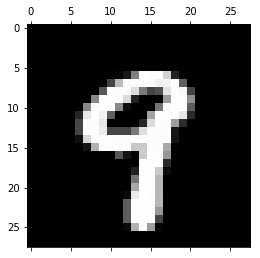

Label: 9
Prediction: 9

Image: 156


<Figure size 432x288 with 0 Axes>

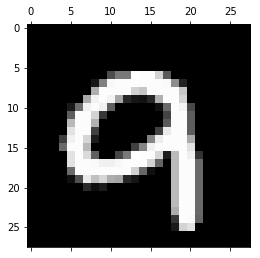

Label: 9
Prediction: 9

Image: 157


<Figure size 432x288 with 0 Axes>

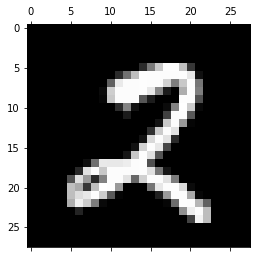

Label: 2
Prediction: 2

Image: 158


<Figure size 432x288 with 0 Axes>

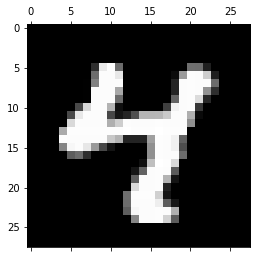

Label: 4
Prediction: 4

Image: 159


<Figure size 432x288 with 0 Axes>

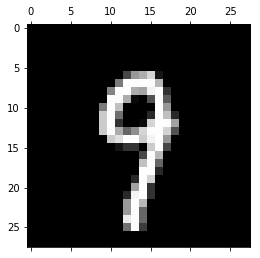

Label: 9
Prediction: 9

Image: 160


<Figure size 432x288 with 0 Axes>

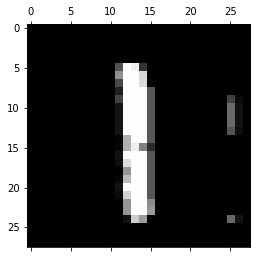

Label: 1
Prediction: 8

Image: 161


<Figure size 432x288 with 0 Axes>

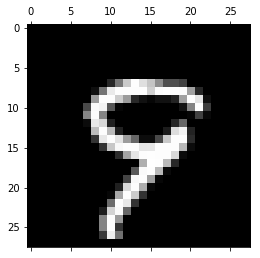

Label: 9
Prediction: 9

Image: 162


<Figure size 432x288 with 0 Axes>

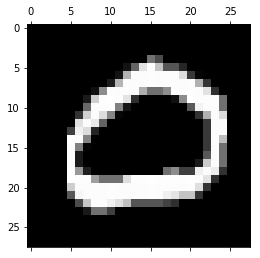

Label: 0
Prediction: 0

Image: 163


<Figure size 432x288 with 0 Axes>

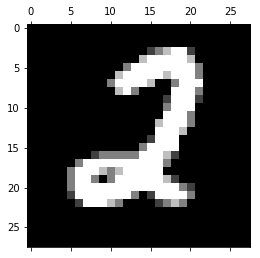

Label: 2
Prediction: 2

Image: 164


<Figure size 432x288 with 0 Axes>

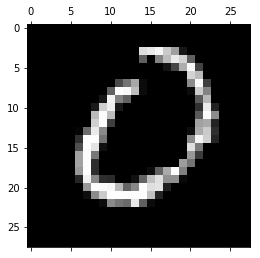

Label: 0
Prediction: 0

Image: 165


<Figure size 432x288 with 0 Axes>

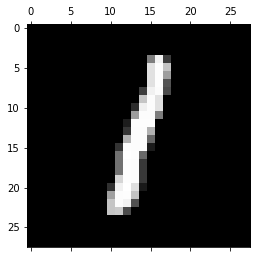

Label: 1
Prediction: 1

Image: 166


<Figure size 432x288 with 0 Axes>

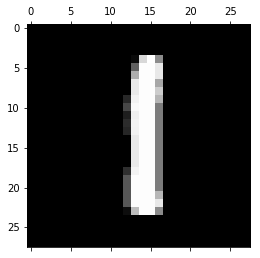

Label: 1
Prediction: 1

Image: 167


<Figure size 432x288 with 0 Axes>

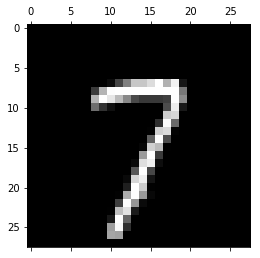

Label: 7
Prediction: 7

Image: 168


<Figure size 432x288 with 0 Axes>

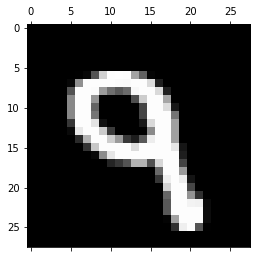

Label: 9
Prediction: 9

Image: 169


<Figure size 432x288 with 0 Axes>

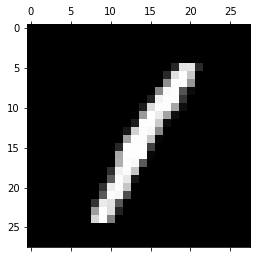

Label: 1
Prediction: 1

Image: 170


<Figure size 432x288 with 0 Axes>

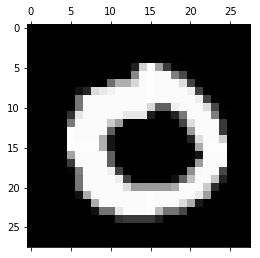

Label: 0
Prediction: 0

Image: 171


<Figure size 432x288 with 0 Axes>

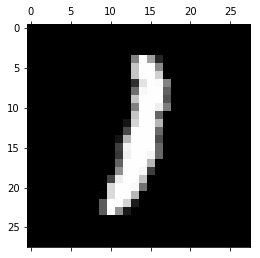

Label: 1
Prediction: 1

Image: 172


<Figure size 432x288 with 0 Axes>

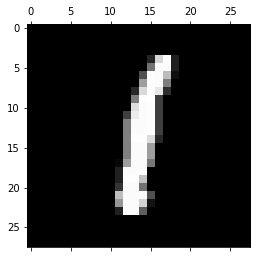

Label: 1
Prediction: 1

Image: 173


<Figure size 432x288 with 0 Axes>

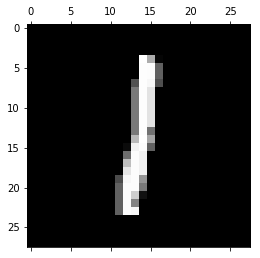

Label: 1
Prediction: 1

Image: 174


<Figure size 432x288 with 0 Axes>

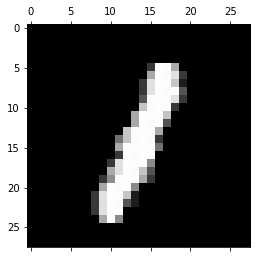

Label: 1
Prediction: 1



In [27]:
index1=155
index2=175
NN = MNI_NN
DATA = DMNI
plot_test(index1,index2,NN,DATA)